# [MNIST: Elastic Distortions](@id elastic)

In this example we are going to use Augmentor on the famous
**MNIST database of handwritten digits** [MNIST1998] to
reproduce the elastic distortions discussed in [SIMARD2003].
It may be interesting to point out, that the way Augmentor
implements distortions is a little different to how it is
described by the authors of the paper.
This is for a couple of reasons, most notably that we want the
parameters for our deformations to be independent of the size
of image it is applied on. As a consequence the
parameter-numbers specified in the paper are not 1-to-1
transferable to Augmentor.

If the effects are sensible for the dataset, then applying
elastic distortions can be a really effective way to improve
the generalization ability of the network.
That said, our implementation of [`ElasticDistortion`](@ref)
has a lot of possible parameters to choose from. To that end,
we will introduce a simple strategy for interactively
exploring the parameter space on our dataset of interest.

## Loading the MNIST Trainingset

In order to access and visualize the MNIST images we employ
the help of two additional Julia packages. In the interest of
time and space we will not go into great detail about their
functionality. Feel free to click on their respective names to
find out more information about the utility they can provide.

- [Images.jl](https://github.com/JuliaImages/Images.jl) will
  provide us with the necessary tools for working with image
  data in Julia.

- [MLDatasets.jl](https://github.com/JuliaML/MLDatasets.jl)
  has an MNIST submodule that offers a convenience interface
  to read the MNIST database.

The function `MNIST.traintensor` returns the MNIST training
images corresponding to the given indices as a
multi-dimensional array. These images are stored in the native
horizontal-major memory layout as a single floating point
array, where all values are scaled to be between 0.0 and 1.0.

In [1]:
using Images, MLDatasets
train_tensor = MNIST.traintensor()
@show summary(train_tensor);

summary(train_tensor) = "28×28×60000 Array{N0f8,3}"


This horizontal-major format is the standard way of utilizing
this dataset for training machine learning models.
In this tutorial, however, we are more interested in working
with the MNIST images as actual Julia images in vertical-major
layout, and as black digits on white background.

We can convert the "tensor" to a `Colorant` array using the
provided function `MNIST.convert2image`.
This way, Julia knows we are dealing with image data and can
tell programming environments such as Juypter how to visualize
it. If you are working in the terminal you may want to use the
package [ImageInTerminal.jl](https://github.com/JuliaImages/ImageInTerminal.jl)

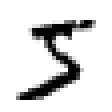

In [2]:
train_images = MNIST.convert2image(train_tensor)
img_1 = train_images[:,:,1] # show first image

## Visualizing the Effects

Before applying an operation (or pipeline of operations) on
some dataset to train a network, we strongly recommend
investing some time in selecting a decent set of hyper
parameters for the operation(s). A useful tool for tasks like
this is the package [Interact.jl](https://github.com/JuliaGizmos/Interact.jl).
We will use this package to define a number of widgets for
controlling the parameters to our operation.

Note that while the code below only focuses on configuring
the parameters of a single operation, specifically
[`ElasticDistortion`](@ref), it could also be adapted to tweak
a whole pipeline. Take a look at the corresponding section in
[High-level Interface](@ref pipeline) for more information
on how to define and use a pipeline.

Interact.Checkbox(1: "input" = true Bool , "unpaused", true)

1.299760103225708

Interact.Options{:SelectionSlider,Any}(4: "input-2" = 50 Any , "image_index", 50, "50", 50, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(6: "input-3" = 11 Any , "grid_size", 11, "11", 9, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10,"11"=>11,"12"=>12…), Dict{Any,Any}(Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(19, "19"),Pair{Any,Any}(17, "17"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(4, "4")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(8: "input-4" = 0.3 Any , "scale", 0.3, "0.3", 3, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5), Dict{Any,Any}(Pair{Any,Any}(0.4, "0.4"),Pair{Any,Any}(0.3, "0.3"),Pair{Any,Any}(0.5, "0.5"),Pair{Any,Any}(0.2, "0.2"),Pair{Any,Any}(0.1, "0.1"))), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(10: "input-5" = 3 Any , "sigma", 3, "3", 3, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5), Dict{Any,Any}(Pair{Any,Any}(4, "4"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(1, "1"))), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(12: "input-6" = 3 Any , "iterations", 3, "3", 3, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6), Dict{Any,Any}(Pair{Any,Any}(4, "4"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(1, "1"))), Any[], Any[], true, "horizontal")

Interact.Checkbox(14: "input-7" = true Bool , "free_border", true)

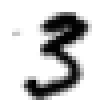

In [3]:
# These two package will provide us with the capabilities
# to perform interactive visualisations in a jupyter notebook
using Augmentor, Interact, Reactive

# The manipulate macro will turn the parameters of the
# loop into interactive widgets.
@manipulate for
        unpaused = true,
        ticks = fpswhen(signal(unpaused), 5.),
        image_index = 1:100,
        grid_size = 3:20,
        scale = .1:.1:.5,
        sigma = 1:5,
        iterations = 1:6,
        free_border = true
    op = ElasticDistortion(grid_size, grid_size, # equal width & height
                           sigma = sigma,
                           scale = scale,
                           iter = iterations,
                           border = free_border)
    augment(train_images[:, :, image_index], op)
end

Congratulations! With just a few simple lines of code, you
created a simple interactive tool to visualize your image
augmentation pipeline. Once you found a set of parameters that
you think are appropriate for your dataset you can go ahead
and train your model.

## References

**MNIST1998**: LeCun, Yan, Corinna Cortes, Christopher J.C. Burges. ["The MNIST database of handwritten digits"](http://yann.lecun.com/exdb/mnist/) Website. 1998.

**SIMARD2003**: Simard, Patrice Y., David Steinkraus, and John C. Platt. ["Best practices for convolutional neural networks applied to visual document analysis."](https://www.microsoft.com/en-us/research/publication/best-practices-for-convolutional-neural-networks-applied-to-visual-document-analysis/) ICDAR. Vol. 3. 2003.